# Leg reversion study
---

In [41]:
from data_pre_processing import *
from pair_finder import *
from back_tester import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression


## Data
---

In [42]:

#BTC and WBTC
#-------------------------------------------
#prices = pd.read_csv("binance_data/Wrapped BTC/2024/1m/merged_closing_prices.csv", index_col=0, parse_dates=True)


#SOL and BNSOL
#-------------------------------------------
#prices = pd.read_csv('binance_data/SOL_and_BNSOL/2025/1m/merged_closing_prices.csv', index_col=0, parse_dates=True)

#ETH and WBTC
#-------------------------------------------
#prices = pd.read_csv('binance_data/ETH_and_WBETH/2024/1m/merged_closing_prices.csv', index_col=0, parse_dates=True)

#Top 100
#-------------------------------------------
prices = pd.read_csv('binance_data/top_100_tickers/2024/1m/merged_closing_prices.csv', index_col=0, parse_dates=True)

In [43]:
prices = prices[['XRP/USDT_2024_1m', 'ADA/USDT_2024_1m']]

#prices = prices[['DOT/USDT_2024_1m', 'XTZ/USDT_2024_1m']]

#BCH/USDT_2024_1m & DOGE/USDT_2024_1m
#-------------------------------------------
#prices = prices[['BCH/USDT_2024_1m', 'DOGE/USDT_2024_1m']]

#GALA/USDT_2024_1m & GRT/USDT_2024_1m,0.0056584346126191745,-4.071777010162084
#-------------------------------------------
#prices = prices[['GALA/USDT_2024_1m', 'GRT/USDT_2024_1m']]

In [44]:
#Filter prices from January 2024 to March 2024
#-------------------------------------------

prices = prices.loc['2024-01-01':'2024-06-30']


## Params
---

In [45]:
#Params:
window_size = 1440
entry_threshold= 3 #3 was prev
exit_threshold= 0
stop_loss_threshold = 100

## Investigation
---

In [46]:
sym1, sym2 = prices.columns
print(f"\nTesting strategy on pair: {sym1} and {sym2} ...")
S1 = prices[sym1]
S2 = prices[sym2]

# Compute the spread series and beta_series 
spread_series, beta_series, alpha_series = compute_spread_series(S1, S2, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series, rolling_mean, rolling_std = compute_rolling_zscore(spread_series, window_size)

#                                   FOR CLOSING PRICE DATA
#------------------------------------------------------------------------------------------
# Generate trading signals (positions) based on the spread's z-score
positions, trade_entries, trade_exits = backtest_pair_rolling(spread_series,S1,S2,zscore_series, entry_threshold, exit_threshold, stop_loss_threshold)



Testing strategy on pair: XRP/USDT_2024_1m and ADA/USDT_2024_1m ...
Total trades closed: 151 (Wins=151, Losses=0)
Win rate: 1.00


In [47]:
initial_capital = 10_000.0
#tx_cost= 0.00031 #0.031% transaction cost
tx_cost= 0.00025 #0.025% transaction cost #Binance level 5 Maker Cost

trade_profits, net_trade_profits_S1, net_trade_profits_S2,cumulative_profit_series, entry_times, exit_times = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series, tx_cost)

Trade Num: 0
-----------------------------------------------
Trade type: -1, Entry time: 2024-01-03 04:49:00, Exit time: 2024-01-03 11:07:00
Net Trade profit (includes fees): 32.85347954816128
Beta at entry (Not the absolute value): 0.3326158939606412
Notional S1: 7504.037769112298, Notional S2: 2495.9622308877024, Shares S1 : 11850.97563031001, Shares S2: 4089.7300194784575
Percentage change S1: -0.38%, Percentage change S2: 0.38%
Trade Num: 1
-----------------------------------------------
Trade type: 1, Entry time: 2024-01-03 11:55:00, Exit time: 2024-01-03 13:48:00
Net Trade profit (includes fees): -434.76550175884813
Beta at entry (Not the absolute value): 0.3219468191743844
Notional S1: 7564.60082580739, Notional S2: 2435.3991741926106, Shares S1 : 12308.169257740627, Shares S2: 4093.1078557859005
Percentage change S1: -7.96%, Percentage change S2: -7.06%
Trade Num: 2
-----------------------------------------------
Trade type: 1, Entry time: 2024-01-06 06:56:00, Exit time: 2024-0

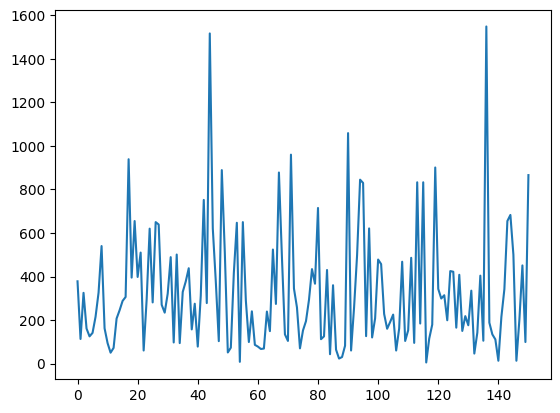

In [48]:
trade_durations = []
for entry, exit in zip(entry_times, exit_times):
    duration = (exit - entry).total_seconds() / 60  # Convert to minutes
    trade_durations.append(duration)

plt.plot(trade_durations)

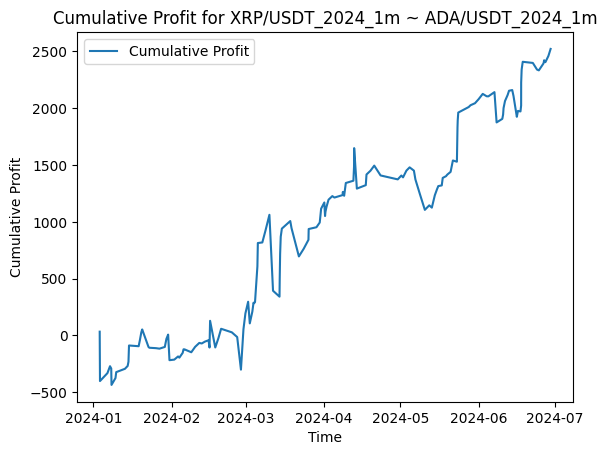

In [49]:
plt.plot(cumulative_profit_series, label='Cumulative Profit')
plt.title(f"Cumulative Profit for {sym1} ~ {sym2}")
plt.xlabel('Time')
plt.ylabel('Cumulative Profit')
plt.legend()

In [50]:
#Compute non-stop loss win rate

trade_losses = [profit for profit in trade_profits if profit < 0]
trade_wins = [profit for profit in trade_profits if profit > 0]


if(stop_loss_threshold > 50):

    print(f"Average trade wins: {np.mean(trade_wins):.2f}")
    print(f"Average trade losses: {np.mean(trade_losses):.2f}")
    print(f"Number of wins: {len(trade_wins)}")
    print(f"Number of losses: {len(trade_losses)}")
    non_stop_loss_win_rate = len(trade_wins) / (len(trade_wins) + len(trade_losses)) * 100
    print(f"Non-stop loss win rate: {non_stop_loss_win_rate:.2f}%")



Average trade wins: 68.61
Average trade losses: -98.16
Number of wins: 104
Number of losses: 47
Non-stop loss win rate: 68.87%


In [51]:
#Percentage changes in S1 and S2 each trade
trade_percentage_changes = []
for entry_time, exit_time in zip(entry_times, exit_times):
    # Calculate percentage change for S1 and S2
    price_change_S1 = (S1[exit_time] - S1[entry_time]) / S1[entry_time] * 100
    price_change_S2 = (S2[exit_time] - S2[entry_time]) / S2[entry_time] * 100
    trade_percentage_changes.append((price_change_S1, price_change_S2))

#Average absolute percentage change in S1 and S2
average_absolute_percentage_changes = [abs(s1+s2)/2 for s1, s2 in trade_percentage_changes]

#Compute abs trade profits 
abs_trade_profits = [abs(profit) for profit in trade_profits]
#Compute average trade profits

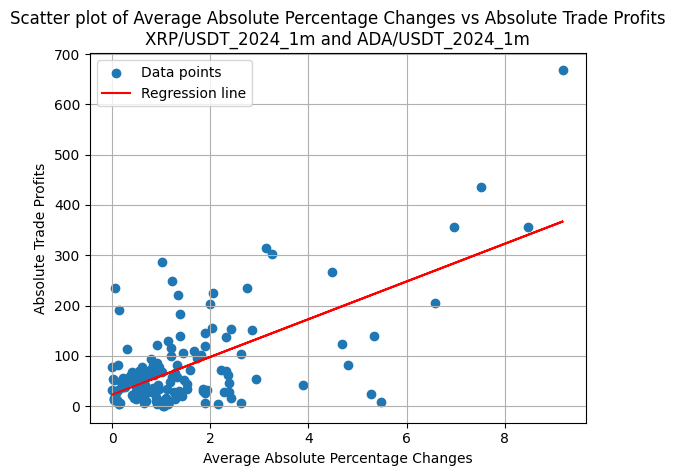

Correlation between average absolute percentage changes and absolute trade profits: 0.6509


In [52]:
#Scatter plot for average_absolute_percentage_changes vs abs_trade_profits with regression line

# Fit a linear regression model

X = np.array(average_absolute_percentage_changes).reshape(-1, 1)
y = np.array(abs_trade_profits)
model = LinearRegression()
model.fit(X, y)
# Predict y values
y_pred = model.predict(X)
# Plot the scatter plot with regression line
plt.scatter(average_absolute_percentage_changes, abs_trade_profits, label='Data points')
plt.plot(average_absolute_percentage_changes, y_pred, color='red', label='Regression line')
plt.xlabel('Average Absolute Percentage Changes')
plt.ylabel('Absolute Trade Profits')
plt.title(f'Scatter plot of Average Absolute Percentage Changes vs Absolute Trade Profits\n{sym1} and {sym2}')
plt.legend()
plt.grid()
plt.show()



#Compute correlation between average_absolute_percentage_changes and abs_trade_profits
correlation = np.corrcoef(average_absolute_percentage_changes, abs_trade_profits)[0, 1]
print(f"Correlation between average absolute percentage changes and absolute trade profits: {correlation:.4f}")


In [53]:
#Check Effect Of net Exposure 
beta_series_trades = beta_series[entry_times]

avg_beta = np.mean(beta_series_trades)

if(avg_beta < 1):
    net_exposure = "S1"
else:
    net_exposure = "S2"

print("avg_beta: ", avg_beta)
print(f"Net exposure: {net_exposure}")



avg_beta:  0.4858322260947798
Net exposure: S1


In [54]:
#An example of a trade where you were net long S1 but still made profit due to S2's hedge, where S2 moved more than S1

# Trade type: -1, Entry time: 2024-03-18 03:12:00, Exit time: 2024-03-18 05:41:00
# Net Trade profit (includes fees): 58.2461918883329
# Beta at entry (Not the absolute value): 0.6246522836635335
# Notional S1: 6155.163231267156, Notional S2: 3844.836768732843, Shares S1 : 9871.953859289744, Shares S2: 5721.483286804826
# Percentage change S1: 0.38%, Percentage change S2: 2.26%
# Trade Num: 65

In [55]:
#Check if losses were caused due to losses in leg that you are nex exposed to

positions_trades = list(positions[entry_times])
S1_trade_returns = [percentage_changes[0] for percentage_changes in trade_percentage_changes]
S2_trade_returns = [percentage_changes[1] for percentage_changes in trade_percentage_changes]

net_exposed_return = []

if net_exposure == "S1":
    net_exposed_return = S1_trade_returns
elif net_exposure == "S2":
    net_exposed_return = S2_trade_returns

losses_due_to_exposure = 0

for position, net_exposed_return, trade_profit in zip(positions_trades,net_exposed_return,trade_profits):

    if(position == 1 and net_exposed_return < 0 and trade_profit < 0 or position == -1 and net_exposed_return > 0 and trade_profit < 0):
        losses_due_to_exposure +=1
    
    elif trade_profit < 0 :
        print(f"Position {position}, Net Exposed Return: {net_exposed_return}, Trade Profit: {trade_profit}")

    # elif (position == 1 and net_exposed_return < 0 and trade_profit > 0 or position == -1 and net_exposed_return > 0 and trade_profit > 0):

    #     print(f"Position {position}, Net Exposed Return: {net_exposed_return}, Trade Profit: {trade_profit}")



print(f"Number of trades where losses were due to exposure: {losses_due_to_exposure}")
print(f"Percentage of losses caused due to exposure: {losses_due_to_exposure / len(trade_losses) * 100:.2f}%")

Position -1, Net Exposed Return: -1.2016522718738194, Trade Profit: -7.294908950301429
Position -1, Net Exposed Return: -0.09414422895877536, Trade Profit: -4.279834803775282
Position -1, Net Exposed Return: -0.36545489517215096, Trade Profit: -10.80549943122497
Position -1, Net Exposed Return: -0.7276302851523945, Trade Profit: -0.6544443969333695
Position 1, Net Exposed Return: 0.8998435054773178, Trade Profit: -25.348222819515666
Position 1, Net Exposed Return: 0.9142857142857193, Trade Profit: -4.684787102287828
Position 1, Net Exposed Return: 0.09061254077565349, Trade Profit: -64.03921265961198
Position 1, Net Exposed Return: 0.5098324836125318, Trade Profit: -234.67908475839656
Position 1, Net Exposed Return: 2.657369016208067, Trade Profit: -41.61540430959296
Position 1, Net Exposed Return: 1.2086513994910846, Trade Profit: -5.608606718707781
Position 1, Net Exposed Return: 0.6761722769366364, Trade Profit: -51.98537848111076
Position -1, Net Exposed Return: -0.9537665696734587

In [56]:

#Compute beta series returns
beta_series_returns = beta_series.pct_change().dropna()

#Compute variance of beta series returns
variance_beta_series = beta_series_returns.std() * 100
print(f"Variance of beta series returns: {variance_beta_series:.4f}")


#Volatility of the spread
z_score_spread_std = zscore_series.std()
print(f"Spread Standard Deviation: {z_score_spread_std:.4f}")

Variance of beta series returns: 64.6602
Spread Standard Deviation: 1.2638


In [57]:

#Get actual Betas used for each trade entry
beta_entries = [beta_series[entry] for entry in entry_times]

trade_ranges = [(entry, exit) for entry, exit in zip(entry_times, exit_times)]

#Get beta series in the trade ranges

beta_series_trade_ranges = [beta_series[entry:exit].iloc[1:] for entry, exit in trade_ranges] #iloc[1:] to exclude the first beta value which is the same as the entry beta

#Calculate the absolute difference between the beta at the trade entry and the betas in the trade range
absolute_delta_betas = [np.abs(entry_beta - beta_range) for entry_beta, beta_range in zip(beta_entries, beta_series_trade_ranges)]

#Calculate the mean delta beta for each trade
mean_absolute_delta_betas = [np.mean(delta) for delta in absolute_delta_betas]


In [58]:
#Calcilate correlation with trade durations vs mean_absolute_delta_betas


# Compute the correlation coefficient
correlation_durations = np.corrcoef(trade_durations, mean_absolute_delta_betas)[0, 1]

correlation_durations


np.float64(0.2925727562447961)

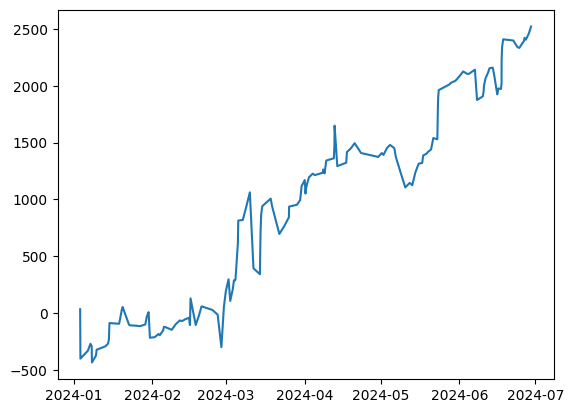

In [59]:
plt.plot(cumulative_profit_series)

In [60]:
# #Calculate correlation with mean_absolute_delta_betas and cumulative profit series

# #Perfrom linear regression
# X = np.array(mean_absolute_delta_betas).reshape(-1, 1)
# y = np.array(trade_profits)
# model = LinearRegression()
# model.fit(X, y)
# # Predict y values
# y_pred = model.predict(X)
# # Plot the scatter plot with regression line
# plt.scatter(mean_absolute_delta_betas, trade_profits, label='Data points')
# plt.plot(mean_absolute_delta_betas, y_pred, color='red', label='Regression line')
# plt.xlabel('Mean Absolute Delta Betas')
# plt.ylabel('Trade Profits')
# plt.title(f'Scatter plot of Mean Absolute Delta Betas vs Trade Profits\n{sym1} and {sym2}')
# plt.grid()
# plt.show()

# #Regression R ^2
# r_squared = model.score(X, y)
# print(f"R^2: {r_squared:.4f}")




# # plt.scatter(mean_absolute_delta_betas, trade_profits)
# # plt.axhline(0, color = 'red')
# # plt.legend()


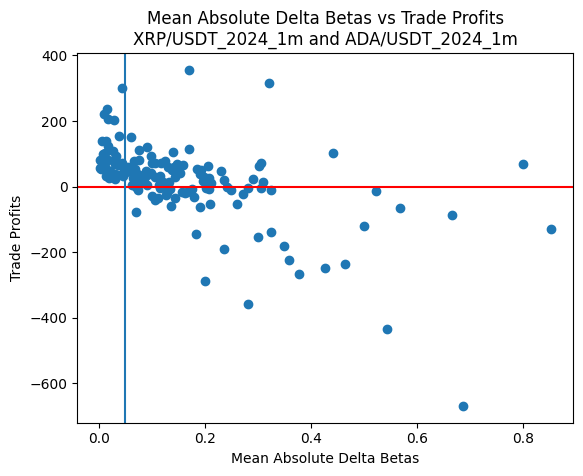

In [61]:
plt.scatter(mean_absolute_delta_betas, trade_profits)
plt.xlabel('Mean Absolute Delta Betas')
plt.ylabel('Trade Profits')
plt.title(f'Mean Absolute Delta Betas vs Trade Profits\n{sym1} and {sym2}')
plt.axhline(0, color = 'red')
plt.axvline(0.05)


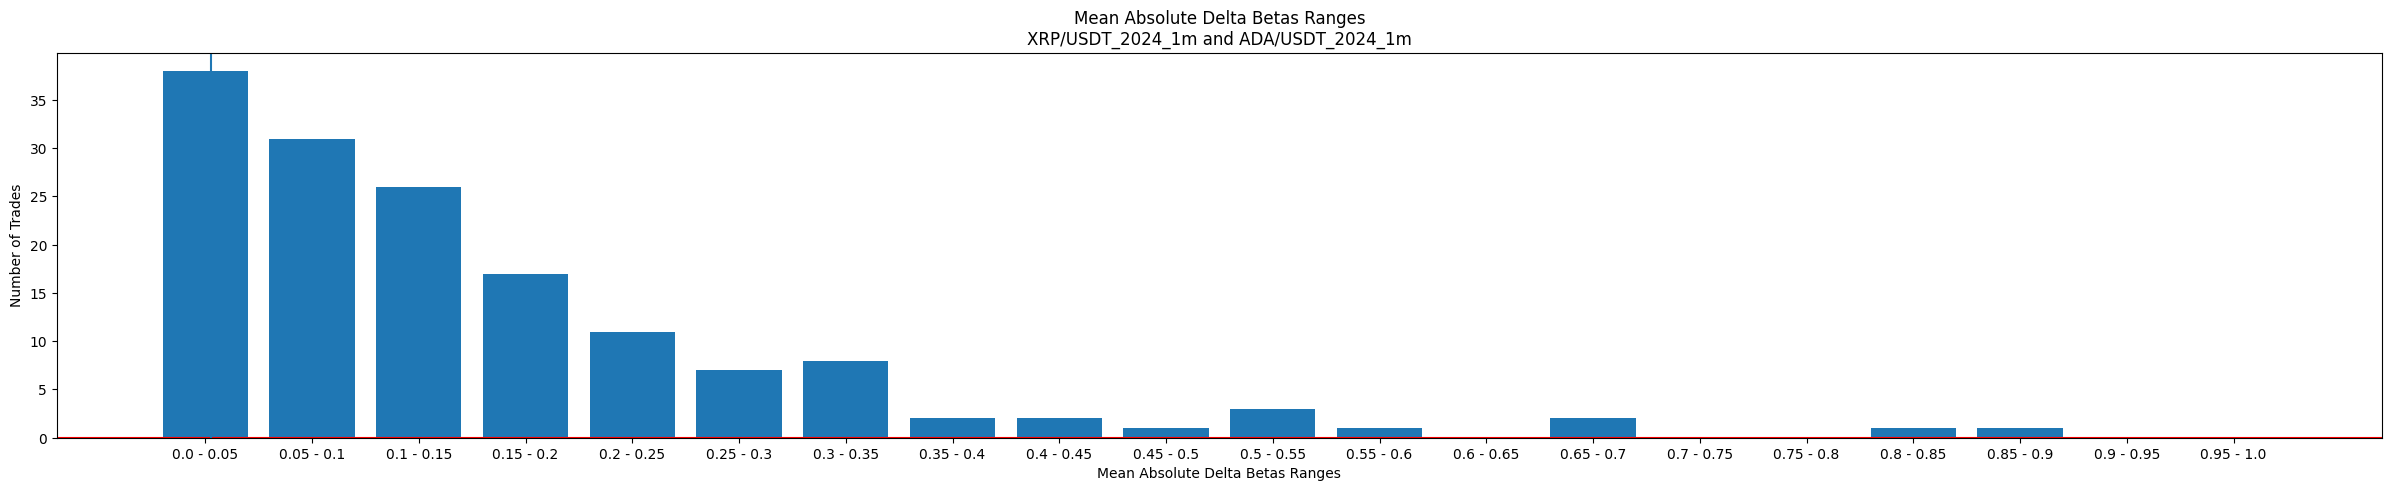

In [64]:
#Create ranges from mean_absolute_delta_betas
ranges = []

for i in range(0, 100, 5):
    ranges.append((i/100, (i+5)/100))

#Count the number of trades where the mean absolute delta beta is in the range
mean_absolute_delta_betas_ranges = []
for i in range(len(ranges)):
    mean_absolute_delta_betas_ranges.append(0)

#Count the number of trades where the mean absolute delta beta is in the range
for mean_absolute_delta_beta in mean_absolute_delta_betas:
    for i in range(len(ranges)):
        if mean_absolute_delta_beta >= ranges[i][0] and mean_absolute_delta_beta < ranges[i][1]:
            mean_absolute_delta_betas_ranges[i] += 1
            break

plt.figure(figsize=(30, 5))
#Plot the ranges
plt.bar(range(len(ranges)), mean_absolute_delta_betas_ranges)
plt.xticks(range(len(ranges)), [f"{ranges[i][0]} - {ranges[i][1]}" for i in range(len(ranges))])
plt.xlabel('Mean Absolute Delta Betas Ranges')
plt.ylabel('Number of Trades')
plt.title(f'Mean Absolute Delta Betas Ranges\n{sym1} and {sym2}')
plt.axhline(0, color = 'red')
plt.axvline(0.05)
plt.show()

In [65]:
trades_data = list(zip(trade_profits,mean_absolute_delta_betas))

trade_win_rates = []
probability_of_losses = []

for range in ranges:
    trade_wins = 0
    trade_losses = 0
    probability_of_loss = 0
    for trade_data in trades_data:
        if trade_data[1] >= range[0] and trade_data[1] < range[1]:
            if trade_data[0] > 0:
                trade_wins += 1
            else:
                trade_losses += 1
    if trade_wins + trade_losses > 0:
        trade_wins_percentage = trade_wins / (trade_wins + trade_losses) * 100
        probability_of_loss = trade_losses / (trade_wins + trade_losses) * 100
        print(f"Range: {range[0]} - {range[1]}, Trade wins: {trade_wins}, Trade losses: {trade_losses}, Probability of loss: {probability_of_loss:.2f}%")
        
    trade_win_rates.append(trade_wins_percentage)
    probability_of_losses.append(probability_of_loss)



 
    

    

Range: 0.0 - 0.05, Trade wins: 38, Trade losses: 0, Probability of loss: 0.00%
Range: 0.05 - 0.1, Trade wins: 28, Trade losses: 3, Probability of loss: 9.68%
Range: 0.1 - 0.15, Trade wins: 16, Trade losses: 10, Probability of loss: 38.46%
Range: 0.15 - 0.2, Trade wins: 9, Trade losses: 8, Probability of loss: 47.06%
Range: 0.2 - 0.25, Trade wins: 6, Trade losses: 5, Probability of loss: 45.45%
Range: 0.25 - 0.3, Trade wins: 1, Trade losses: 6, Probability of loss: 85.71%
Range: 0.3 - 0.35, Trade wins: 4, Trade losses: 4, Probability of loss: 50.00%
Range: 0.35 - 0.4, Trade wins: 0, Trade losses: 2, Probability of loss: 100.00%
Range: 0.4 - 0.45, Trade wins: 1, Trade losses: 1, Probability of loss: 50.00%
Range: 0.45 - 0.5, Trade wins: 0, Trade losses: 1, Probability of loss: 100.00%
Range: 0.5 - 0.55, Trade wins: 0, Trade losses: 3, Probability of loss: 100.00%
Range: 0.55 - 0.6, Trade wins: 0, Trade losses: 1, Probability of loss: 100.00%
Range: 0.65 - 0.7, Trade wins: 0, Trade losses

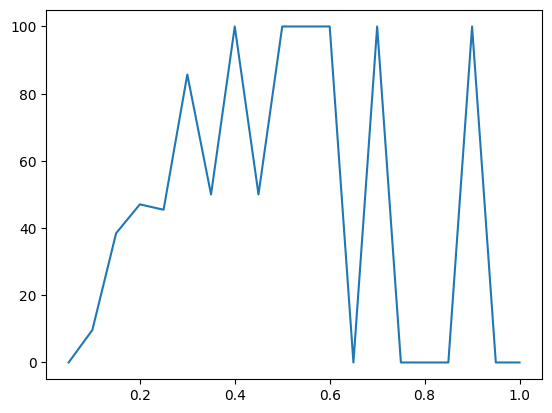

In [66]:
#Plot trade ranges and probability of losses on bar chart

range_ends = [range[1] for range in ranges]

plt.plot(range_ends, probability_of_losses, label='Probability of Losses')
#Plot the ranges




In [40]:
mean_absolute_delta_betas_ranges

[114, 22, 4, 7, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Findings From Study
----

In [393]:
#Losses are due to errors in Beta estimation. Prices move more or less than expected under the estimated ratio, leaving you unhedged.
#Large gains and losses are due to increased volatility in each asset. Larger swings in price lead to larger profits and losses.

#Conversely, if the pair is less tightly linked (or if the cointegration relationship temporarily weakens), both the idiosyncrasies in the raw prices and the increased uncertainty in β will contribute to a more volatile spread


#SO FAR, WE HAVE REVERSION TIME, VOLATILITY OF SPREAD, AND VARIANCE OF BETA SERIES RETURNS, AND 

In [394]:
# THE LESS DELTA NEUTRAL YOU ARE IN A TRADE, THE MORE LIKELY THAT TRADE WILL BE A LOSS (SURELY)